In [1]:
import os.path
import datetime
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 26}

matplotlib.rc('font', **font)

from sklearn import linear_model, model_selection, metrics

In [2]:
data_dir = 'data/'  # this directory should contain all the csv files for this problem
failures = pd.read_csv(os.path.join(data_dir, 'failures.csv'),
                       parse_dates=['datetime'])
failures = failures.join(pd.get_dummies(failures.failure)).drop('failure', axis=1)
failures = (failures.groupby(['machineID', 'datetime'])
                    .sum()
                    .sort_index()
           )
failures.head()

comp1  comp2  comp3  comp4
machineID datetime                                       
1         2015-02-04 06:00:00      0      0      1      0
          2015-03-21 06:00:00      1      0      0      0
          2015-04-05 06:00:00      0      0      0      1
          2015-05-05 06:00:00      0      0      1      0
          2015-05-20 06:00:00      0      1      0      0

In [3]:
errors = pd.read_csv(os.path.join(data_dir, 'errors.csv'),
                     parse_dates=['datetime'])
errors = (errors.join(pd.get_dummies(errors.errorID))
                .drop('errorID', axis=1)
                .groupby(['machineID', 'datetime'])
                .sum()
                .sort_index()
                .reset_index()
           )
errors.head()

,machineID,datetime,error1,error2,error3,error4,error5
0,1,2015-01-06 03:00:00,0,0,1,0,0
1,1,2015-02-03 06:00:00,0,0,0,1,0
2,1,2015-02-21 11:00:00,1,0,0,0,0
3,1,2015-02-21 16:00:00,0,1,0,0,0
4,1,2015-03-20 06:00:00,1,0,0,0,0


In [4]:
machines = pd.read_csv(os.path.join(data_dir, 'machines.csv'))
machines = machines.join(pd.get_dummies(machines.model))
machines.drop('model', axis=1, inplace=True)
machines.head()

,machineID,age,model1,model2,model3,model4
0,1,18,0,1,0,0
1,2,7,0,0,0,1
2,3,8,0,0,1,0
3,4,7,0,0,1,0
4,5,2,0,1,0,0


In [5]:
maint = pd.read_csv(os.path.join(data_dir, 'maint.csv'),
                    parse_dates=['datetime'])
fail_comp = maint.comp * maint.IF_FAIL
maint = (maint.join(pd.get_dummies(maint.comp))
              .join(pd.get_dummies(fail_comp), rsuffix='_fail')
              .drop(['comp', 'IF_FAIL', ''], axis=1)
              .groupby(['machineID', 'datetime'])
              .sum()
              .sort_index()
              .reset_index()
        )
maint.head()

,machineID,datetime,comp1,comp2,comp3,comp4,comp1_fail,comp2_fail,comp3_fail,comp4_fail
0,1,2014-07-01 06:00:00,0,0,0,1,0,0,0,0
1,1,2014-09-14 06:00:00,1,1,0,0,0,0,0,0
2,1,2014-11-13 06:00:00,0,0,1,0,0,0,0,0
3,1,2015-01-05 06:00:00,1,0,0,0,0,0,0,0
4,1,2015-01-20 06:00:00,1,0,0,0,0,0,0,0


In [6]:
errors_ = pd.read_csv(os.path.join(data_dir, 'errors.csv'),
                     parse_dates=['datetime'])
maint_ = pd.read_csv(os.path.join(data_dir, 'maint.csv'),
                    parse_dates=['datetime'])

err_maint=errors_.merge(maint_, on=['datetime','machineID'],how='outer')
err_maint.sort_values(by=['machineID', 'datetime'])
comp1=err_maint[(err_maint.comp == 'comp1') & (err_maint.IF_FAIL == 1.0)]
comp2=err_maint[(err_maint.comp == 'comp2') & (err_maint.IF_FAIL == 1.0)]
comp3=err_maint[(err_maint.comp == 'comp3') & (err_maint.IF_FAIL == 1.0)]
comp4=err_maint[(err_maint.comp == 'comp4') & (err_maint.IF_FAIL == 1.0)]

data = []

def time_since_failure(comp_df, i):
    current = comp_df.iloc[i]
    next_row = comp_df.iloc[i+1]
    if current.machineID == next_row.machineID:
        return (current.machineID,
                current.datetime,
                current.comp,
                (next_row.datetime-current.datetime).total_seconds() / (60*60*24),
               )

for comp_df in [comp1, comp2, comp3, comp4]:
    for i in range (len(comp_df)-1):
        data.append(time_since_failure(comp_df, i))


tsf = (pd.DataFrame(filter(None, data), columns=['machineID', 'datetime', 'comp', 'time_since_failure'])
         .set_index(['machineID', 'datetime'])
         .sort_index()
      )
tsf.head()

comp  time_since_failure
machineID datetime                                      
1         2015-02-04 06:00:00  comp3                90.0
          2015-03-21 06:00:00  comp1               240.0
          2015-04-05 06:00:00  comp4                60.0
          2015-05-05 06:00:00  comp3                90.0
          2015-05-20 06:00:00  comp2                30.0

In [7]:
telemetry = pd.read_csv(os.path.join(data_dir, 'telemetry.csv'),
                        parse_dates=['datetime'])
telemetry = telemetry.join(pd.get_dummies(telemetry.datetime.apply(lambda dt: dt.strftime('%A'))))
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,2015-01-01 06:00:00,1,151.919999,530.813578,101.788175,49.604013,0,0,0,0,1,0,0
1,2015-01-01 07:00:00,1,174.522001,535.523532,113.256009,41.515905,0,0,0,0,1,0,0
2,2015-01-01 08:00:00,1,146.912822,456.080746,107.786965,42.099694,0,0,0,0,1,0,0
3,2015-01-01 09:00:00,1,179.530561,503.469990,108.283817,37.847727,0,0,0,0,1,0,0
4,2015-01-01 10:00:00,1,180.544277,371.600611,107.553307,41.467880,0,0,0,0,1,0,0


In [8]:
diagnostics = (errors.merge(maint, on=["datetime", "machineID"], how='outer')
                     .merge(telemetry, on=['datetime', 'machineID'], how='right')
              )

df = machines.merge(diagnostics, on="machineID")
df = (df[(df.datetime >= telemetry.datetime.min()) & (df.datetime <= telemetry.datetime.max())]
        .fillna(0)
        .set_index(['machineID', 'datetime'])
        .sort_index()
)
print len(df), len(telemetry)  # these two should be equal
df.head()

8761000 8761000


age  model1  model2  model3  model4  error1  \
machineID datetime                                                           
1         2015-01-01 06:00:00   18       0       1       0       0     0.0   
          2015-01-01 07:00:00   18       0       1       0       0     0.0   
          2015-01-01 08:00:00   18       0       1       0       0     0.0   
          2015-01-01 09:00:00   18       0       1       0       0     0.0   
          2015-01-01 10:00:00   18       0       1       0       0     0.0   

                               error2  error3  error4  error5    ...      \
machineID datetime                                               ...       
1         2015-01-01 06:00:00     0.0     0.0     0.0     0.0    ...       
          2015-01-01 07:00:00     0.0     0.0     0.0     0.0    ...       
          2015-01-01 08:00:00     0.0     0.0     0.0     0.0    ...       
          2015-01-01 09:00:00     0.0     0.0     0.0     0.0    ...       
          2015-01-01 10:00:00     0.0     0.0     0.0     0.0    ...       

                                   rotate    pressure  vibration  Friday  \
machineID datetime                                                         
1         2015-01-01 06:00:00  530.813578  101.788175  49.604013       0   
          2015-01-01 07:00:00  535.523532  113.256009  41.515905       0   
          2015-01-01 08:00:00  456.080746  107.786965  42.099694       0   
          2015-01-01 09:00:00  503.469990  108.283817  37.847727       0   
          2015-01-01 10:00:00  371.600611  107.553307  41.467880       0   

                               Monday  Saturday  Sunday  Thursday  Tuesday  \
machineID datetime                                                           
1         2015-01-01 06:00:00       0         0       0         1        0   
          2015-01-01 07:00:00       0         0       0         1        0   
          2015-01-01 08:00:00       0         0       0         1        0   
          2015-01-01 09:00:00       0         0       0         1        0   
          2015-01-01 10:00:00       0         0       0         1        0   

                               Wednesday  
machineID datetime                        
1         2015-01-01 06:00:00          0  
          2015-01-01 07:00:00          0  
          2015-01-01 08:00:00          0  
          2015-01-01 09:00:00          0  
          2015-01-01 10:00:00          0  

[5 rows x 29 columns]

In [9]:
y = failures.reset_index()

horizon = 24
y['datetime'] = y.datetime.apply(lambda dt: dt - datetime.timedelta(seconds=60*60*horizon))
y = y.set_index(['machineID', 'datetime'])

X_y = df.join(y, how='left', rsuffix='_y').fillna(0).sort_index()
print len(X_y)
X_y.head()

8761000


age  model1  model2  model3  model4  error1  \
machineID datetime                                                           
1         2015-01-01 06:00:00   18       0       1       0       0     0.0   
          2015-01-01 07:00:00   18       0       1       0       0     0.0   
          2015-01-01 08:00:00   18       0       1       0       0     0.0   
          2015-01-01 09:00:00   18       0       1       0       0     0.0   
          2015-01-01 10:00:00   18       0       1       0       0     0.0   

                               error2  error3  error4  error5   ...     \
machineID datetime                                              ...      
1         2015-01-01 06:00:00     0.0     0.0     0.0     0.0   ...      
          2015-01-01 07:00:00     0.0     0.0     0.0     0.0   ...      
          2015-01-01 08:00:00     0.0     0.0     0.0     0.0   ...      
          2015-01-01 09:00:00     0.0     0.0     0.0     0.0   ...      
          2015-01-01 10:00:00     0.0     0.0     0.0     0.0   ...      

                               Monday  Saturday  Sunday  Thursday  Tuesday  \
machineID datetime                                                           
1         2015-01-01 06:00:00       0         0       0         1        0   
          2015-01-01 07:00:00       0         0       0         1        0   
          2015-01-01 08:00:00       0         0       0         1        0   
          2015-01-01 09:00:00       0         0       0         1        0   
          2015-01-01 10:00:00       0         0       0         1        0   

                               Wednesday  comp1_y  comp2_y  comp3_y  comp4_y  
machineID datetime                                                            
1         2015-01-01 06:00:00          0      0.0      0.0      0.0      0.0  
          2015-01-01 07:00:00          0      0.0      0.0      0.0      0.0  
          2015-01-01 08:00:00          0      0.0      0.0      0.0      0.0  
          2015-01-01 09:00:00          0      0.0      0.0      0.0      0.0  
          2015-01-01 10:00:00          0      0.0      0.0      0.0      0.0  

[5 rows x 33 columns]

In [10]:
predict = ['comp1_y', 'comp2_y', 'comp3_y', 'comp4_y']
features = [
    'error5', 'error1', 'error4', 'error3', 'error2',
    'model4', 'model3', 'model1', 'model2', 
]


def get_x_y(xy):
    y = xy[predict].sum(axis=1)
    y = y.apply(lambda n: n / max(1.0, n))
    X = xy[features]
    weights = 100 * (y+1)
    return X, y, weights
    
xy = X_y.reset_index()

split_ids = [250, 500, 750]
split_dts = [datetime.datetime(2015, 3, 1), datetime.datetime(2015, 6, 1),  datetime.datetime(2015, 9, 1)]

cms = []
coefs = []

for i, (split_id, split_dt) in enumerate(zip(split_ids, split_dts)):
    X, y, w = get_x_y(xy[(xy.machineID <= split_id) & (xy.datetime <= split_dt)].set_index(['machineID', 'datetime']))
    if i+1 == len(split_ids):
        hi_id = xy.machineID.max()
        hi_dt = xy.datetime.max()
    else:
        hi_id = split_ids[i+1]
        hi_dt = split_dts[i+1]
    X_test, y_test, _ = get_x_y(xy[(
        (xy.machineID > split_id) & (xy.machineID <= hi_id) & 
        (xy.datetime > split_dt) & (xy.datetime <= hi_dt)
    )].set_index(['machineID', 'datetime']))
    
    lr = linear_model.LogisticRegression(C=1, penalty='l2')
    lr.fit(X, y, w)
    
    y_hat = lr.predict(X_test)
    
    coefs.append(list(lr.intercept_) + list(lr.coef_.squeeze()))

    cms.append(metrics.confusion_matrix(y_test, y_hat))

/home/matt/.virtualenvs/ds/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


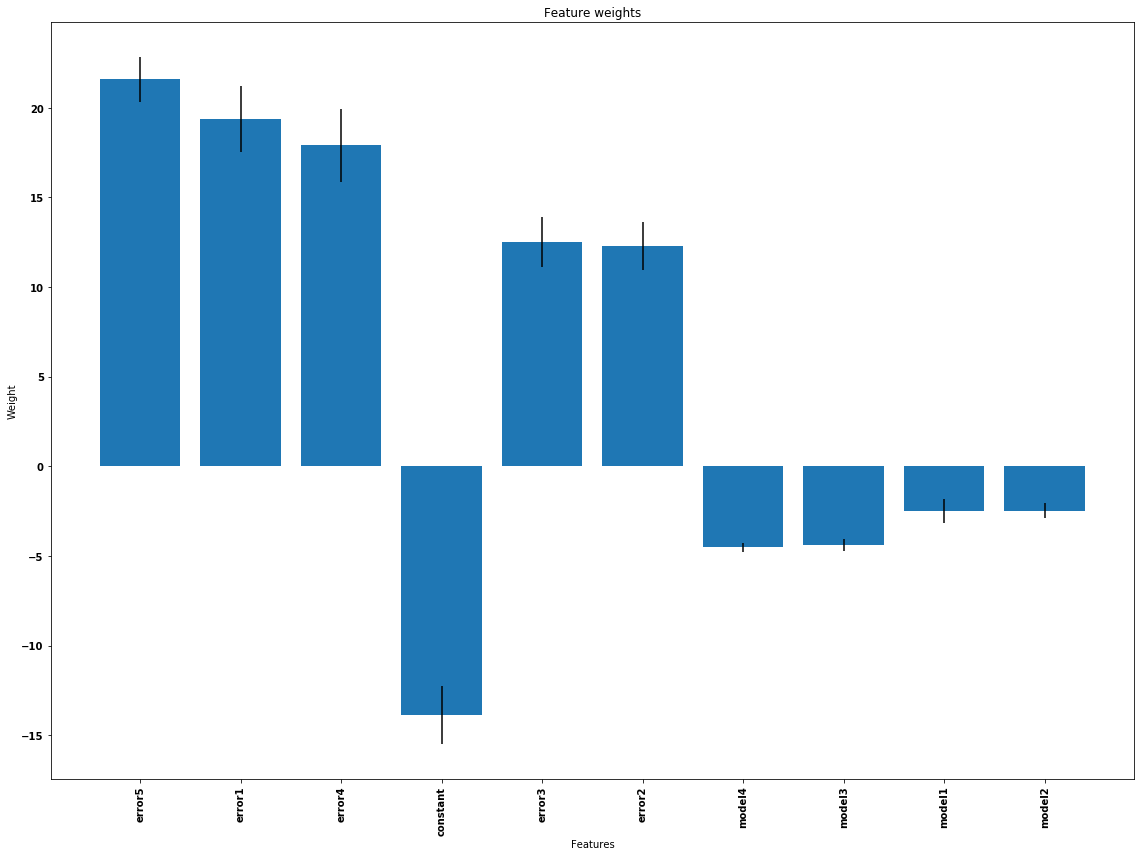

In [11]:
if True:
    feature_names = np.array(['constant'] + list(X.columns))
    coefs = np.vstack(coefs)
    coef_mag = coefs.mean(axis=0)
    coef_std = coefs.std(axis=0)

    idx = np.argsort(np.abs(coef_mag))[::-1]

    
    plt.figure(figsize=(16,12))
    plt.bar(np.arange(len(feature_names)), coef_mag[idx], yerr=coef_std[idx])
    plt.xticks(np.arange(len(feature_names)), feature_names[idx], rotation=90)
    plt.xlabel("Features")
    plt.ylabel("Weight")
    plt.title("Feature weights")
    plt.tight_layout()
    None

In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.4f' # if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]*100, fmt)+'%',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

Normalized confusion matrix
[[9.99857317e-01 1.42682718e-04]
 [0.00000000e+00 1.00000000e+00]]


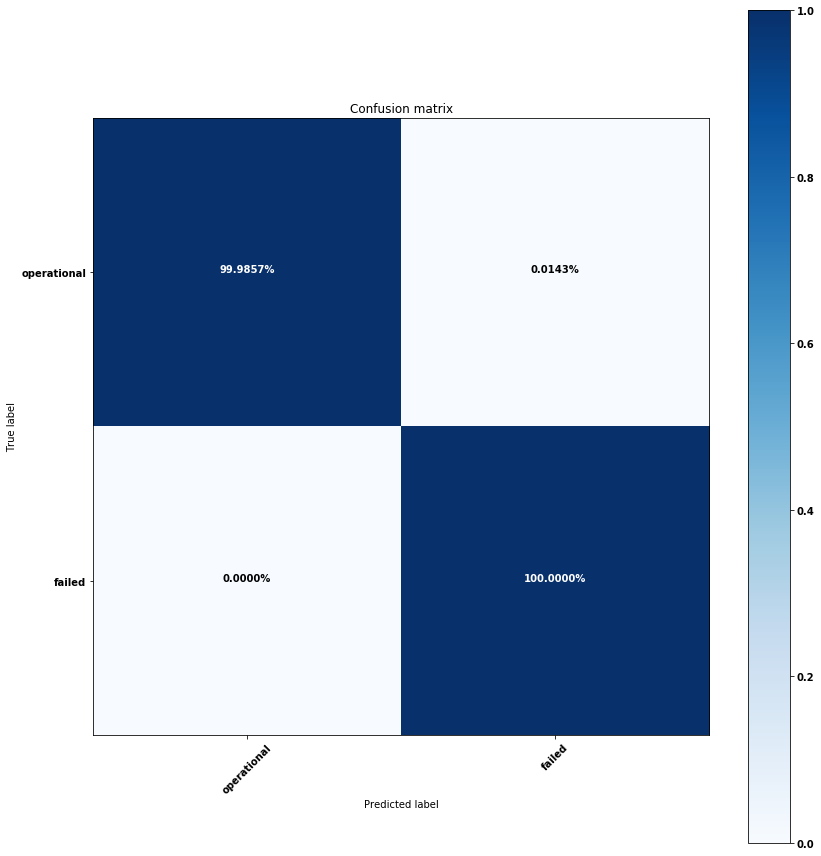

In [13]:
cm = sum(cms) / float(len(split_ids))
plot_confusion_matrix(cm, classes=['operational', 'failed'], normalize=True)